In [1]:
import os
import glob
import numpy as np
import pandas as pd
import nibabel as nib
import scipy.io as sio
import seaborn as sns
import ancillary as ac
import matplotlib as mpl
import matplotlib.pyplot as plt
from nilearn import plotting
from PyPDF2 import PdfFileMerger
from natsort import natsorted
import statsmodels.api as sm
from sklearn.cross_decomposition import CCA
from statsmodels.multivariate.manova import MANOVA
from sklearn.svm import SVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
def zscore(data, axis):
    data -= data.mean(axis=axis, keepdims=True)
    data /= data.std(axis=axis, keepdims=True)
    return np.nan_to_num(data, copy=False)

def correlation(matrix1, matrix2):
    d1 = matrix1.shape[-1]
    d2 = matrix2.shape[-1]

    assert d1 == d2
    assert matrix1.ndim <= 2
    assert matrix2.ndim <= 2
    
    matrix1 = zscore(matrix1.astype(float), matrix1.ndim - 1) / np.sqrt(d1)
    matrix2 = zscore(matrix2.astype(float), matrix2.ndim - 1) / np.sqrt(d2)
    
    if matrix1.ndim >= matrix2.ndim:
        return np.dot(matrix1, matrix2.T)
    else:
        return np.dot(matrix2, matrix1.T)

In [3]:
ukb_smri_data_path = "/Users/xli77/Documents/MIVA/output/UKB_MMIVA_C30_preregSite_SMRI_MancovanOuts_wX_FINAL.mat"
ukb_smri_data = sio.loadmat(ukb_smri_data_path)['MODELUKB0s_ful']
ukb_smri_data_array = ukb_smri_data[0][0][0]
ukb_smri_data_key = np.squeeze(ukb_smri_data[0][0][3])
age_idx = np.where(ukb_smri_data_key==['age_when_attended_assessment_centre_f21003_2_0'])[0][0]
sex_idx = np.where(ukb_smri_data_key==['sex_f31_0_0'])[0][0]
age = ukb_smri_data_array[:, age_idx]
sex = ukb_smri_data_array[:, sex_idx]

In [4]:
datapath="/Users/xli77/Documents/MISA/results/SIVA/fixedSubspace/um2mm/"
subspace_struct_list=['234111','2222211','333111','441111','12x1']
num_subspace_struct=len(subspace_struct_list)

Y = np.zeros((num_subspace_struct,3,2,12,2907)) # S1-4, UA/MSIVA/GICA, M1-2, voxel, source
W = np.zeros((num_subspace_struct,3,2,12,44318)) # S1-4, UA/MSIVA/GICA, M1-2, voxel, source

# Y = np.zeros((num_subspace_struct,3,2,12,1000)) # S1-4, UA/MSIVA/GICA, M1-2, voxel, source
# W = np.zeros((num_subspace_struct,3,2,12,44318)) # S1-4, UA/MSIVA/GICA, M1-2, voxel, source

num_iter=21
corr = np.zeros((num_subspace_struct,9,12,12))
# loss_um=np.zeros((num_subspace_struct,num_iter))
# loss_ummm=np.zeros((num_subspace_struct,num_iter))
# aux_um=np.zeros((num_subspace_struct,num_iter))
# aux_ummm=np.zeros((num_subspace_struct,num_iter))

for i,ss in enumerate(subspace_struct_list):

    # data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging_sz_Y.mat"))
    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging_Y.mat"))
    Y1=np.squeeze(data['Y1'])

    # data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging_sz_Y.mat"))
    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging_Y.mat"))
    Y2=np.squeeze(data['Y2'])

    # data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","mm_neuroimaging_sz_Y.mat"))
    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","mm_neuroimaging_Y.mat"))
    Y3=np.squeeze(data['Y3'])

    Y[i,0,0]=Y1[0]
    Y[i,0,1]=Y1[1]
    Y[i,1,0]=Y2[0]
    Y[i,1,1]=Y2[1]
    Y[i,2,0]=Y3[0]
    Y[i,2,1]=Y3[1]

    # for j in range(2):
    #     for k in range(2):
    #         for l in range(12):
    #             sgn = np.sign(correlation(Y[i,j,k,l],age))
    #             Y[i,j,k,l] = -sgn * Y[i,j,k,l]

    # data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging_sz_W.mat"))
    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging_W.mat"))
    W1=np.squeeze(data['W1'])

    # data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging_sz_W.mat"))
    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging_W.mat"))
    W2=np.squeeze(data['W2'])

    # data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","mm_neuroimaging_sz_W.mat"))
    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","mm_neuroimaging_W.mat"))
    W3=np.squeeze(data['W3'])

    W[i,0,0]=W1[0]
    W[i,0,1]=W1[1]
    W[i,1,0]=W2[0]
    W[i,1,1]=W2[1]
    W[i,2,0]=W3[0]
    W[i,2,1]=W3[1]

    corr[i,0] = np.corrcoef(Y1[0],Y1[0])[:12,:12]
    corr[i,1] = np.corrcoef(Y1[1],Y1[1])[:12,:12]
    corr[i,2] = np.corrcoef(Y1[0],Y1[1])[12:,:12]

    corr[i,3] = np.corrcoef(Y2[0],Y2[0])[:12,:12]
    corr[i,4] = np.corrcoef(Y2[1],Y2[1])[:12,:12]
    corr[i,5] = np.corrcoef(Y2[0],Y2[1])[12:,:12]

    corr[i,6] = np.corrcoef(Y3[0],Y3[0])[:12,:12]
    corr[i,7] = np.corrcoef(Y3[1],Y3[1])[:12,:12]
    corr[i,8] = np.corrcoef(Y3[0],Y3[1])[12:,:12]

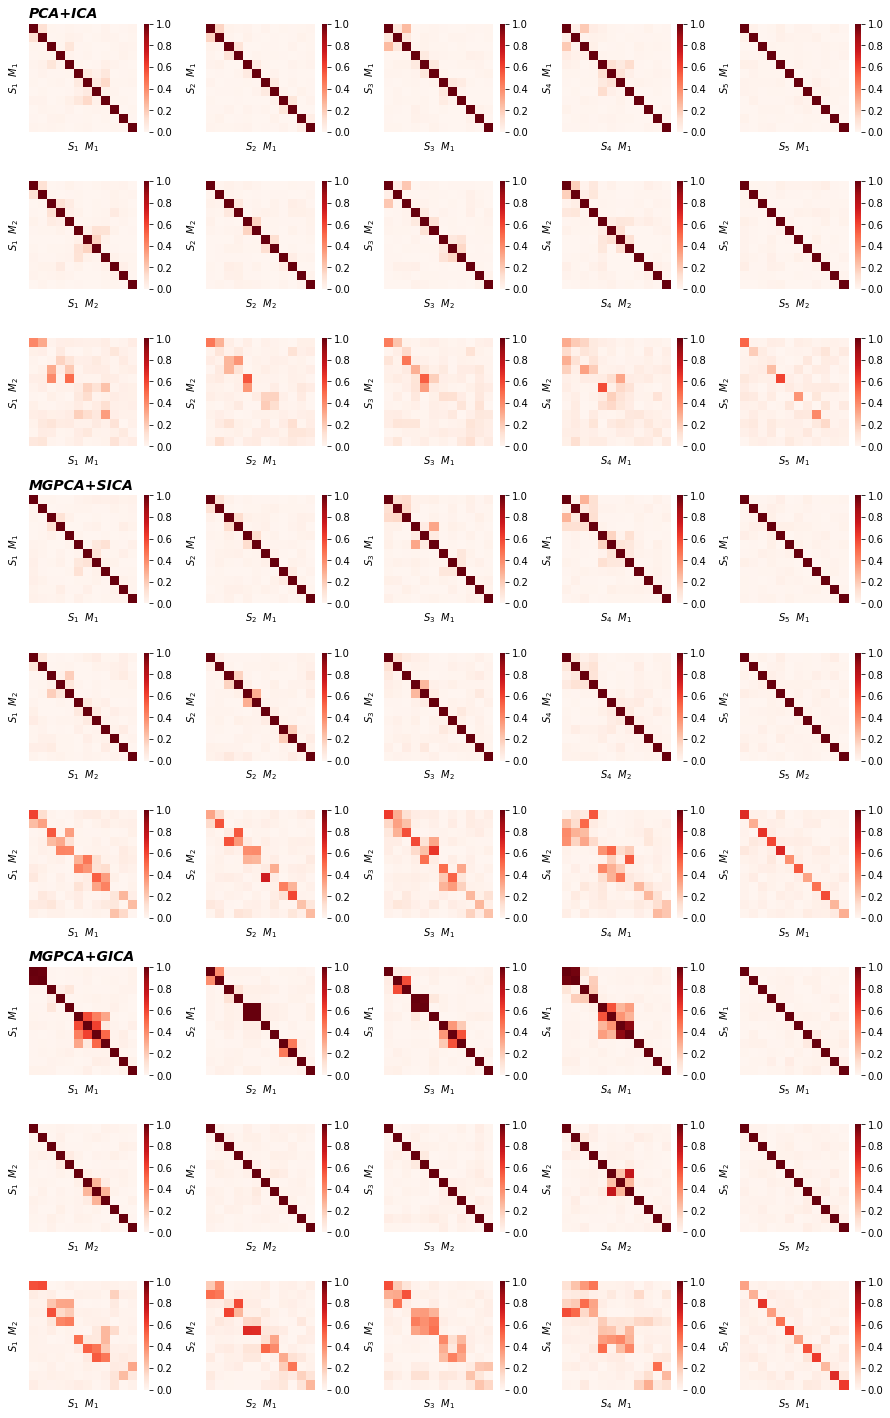

In [5]:
# cmap_list=["YlGn","YlGn","Purples","Purples"]
analysis_list = ["PCA+ICA"]*3+["MGPCA+ICA"]*3+["MGPCA+GICA"]*3

fig,axes=plt.subplots(9,num_subspace_struct,figsize=(2.5*num_subspace_struct,2.2*9))

for i in range(num_subspace_struct):
    for j in range(9):
        if j == 2 or j == 5 or j == 8:
            sns.heatmap(np.abs(corr[i,j]),cmap="Reds",vmin=0,vmax=1,ax=axes[j,i])#Purples
            axes[j,i].set_xlabel(f"$S_{i+1}$  $M_1$")
            axes[j,i].set_ylabel(f"$S_{i+1}$  $M_2$")
            # axes[j,i].set_title(f"$S_{i+1}$  $M_1$ vs $M_2$")
            # axes[j,i].set_title(f"{analysis_list[j]}  $S_{i+1}$  $M_1$ vs $M_2$")#cross-correlation
        else:
            sns.heatmap(np.abs(corr[i,j]),cmap="Reds",vmin=0,vmax=1,ax=axes[j,i])#Purples
            axes[j,i].set_xlabel(f"$S_{i+1}$  $M_{j%3+1}$")
            axes[j,i].set_ylabel(f"$S_{i+1}$  $M_{j%3+1}$")
            # axes[j,i].set_title(f"$~~S_{i+1}$  $M_{j%3+1}$")
            # axes[j,i].set_title(f"{analysis_list[j]}  $S_{i+1}$  $M_{j%3+1}$")#self-correlation($Y$)
        axes[j,i].set_xticks([])
        axes[j,i].set_yticks([])
        # axes[j,i].set_axis_off()
        if i == 0 and j == 0:
            axes[j][i].set_title(analysis_list[j], loc="left", fontsize=14, fontstyle="italic", fontweight="bold")
        if i == 0 and j == 3:
            axes[j][i].set_title(analysis_list[j], loc="left", fontsize=14, fontstyle="italic", fontweight="bold")
        if i == 0 and j == 6:
            axes[j][i].set_title(analysis_list[j], loc="left", fontsize=14, fontstyle="italic", fontweight="bold")

plt.tight_layout()
# plt.savefig("neuroimaging_sz.png",dpi=300)
# plt.savefig("neuroimaging_sz.pdf")
plt.savefig("neuroimaging_gica_iva.png",dpi=300)
# plt.savefig("neuroimaging_gica_iva.pdf")

In [6]:
num_iter=21
loss_um=np.zeros((num_subspace_struct,num_iter))
loss_ummm=np.zeros((num_subspace_struct,num_iter))
loss_mm=np.zeros((num_subspace_struct,num_iter))

for i,ss in enumerate(subspace_struct_list):
    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging.mat"))
    # data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","um_neuroimaging_sz.mat"))
    if ss == '12x1':
        a = np.squeeze(data['aux_um'][2,:])
        loss_um[i,:] = a
    else:
        a = np.squeeze(data['aux_um'][1,:])
        loss_um[i,:] = np.array([a[j][0][0] for j in range(num_iter)])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging.mat"))
    # data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","ummm_neuroimaging_sz.mat"))
    if ss == '12x1':
        a = np.squeeze(data['aux_ummm'][2,:])
        loss_ummm[i,:] = a
    else:
        a = np.squeeze(data['aux_ummm'][1,:])
        loss_ummm[i,:] = np.array([a[j][0][0] for j in range(num_iter)])

    data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","mm_neuroimaging.mat"))
    # data=sio.loadmat(os.path.join(datapath,f"subspace_struct_{ss}","mm_neuroimaging_sz.mat"))
    if ss == '12x1':
        a = np.squeeze(data['aux_mm'][2,:])
        loss_mm[i,:] = a
    else:
        a = np.squeeze(data['aux_mm'][1,:])
        loss_mm[i,:] = np.array([a[j][0][0] for j in range(num_iter)])

In [7]:
loss_um_min = np.min(loss_um,axis=1)
loss_ummm_min = np.min(loss_ummm,axis=1)
loss_mm_min = np.min(loss_mm,axis=1)

print(loss_um_min)
print(loss_ummm_min)
print(loss_mm_min)

[47.73528799 47.81060931 47.76835435 47.77763907 47.99907228]
[46.79423777 46.77480401 46.79766108 46.89191746 46.92389998]
[30.81693856 30.88193339 30.79381001 31.09619339 30.87098566]
